In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
import torch.nn.utils as utils

class GammaNAMLSS(nn.Module):
    def __init__(self, n_covariates, hidden_size=8, intercept=False):
        super(GammaNAMLSS, self).__init__()

        self.submodules = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 2)
            ) for _ in range(n_covariates)
        ])

        self.use_intercept = intercept
        if self.use_intercept:
            self.intercept = nn.Parameter(torch.zeros(2))

    def forward(self, x):
        param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
        x = torch.stack(param_mat_list, dim=1)
        alpha_components = F.softplus(x[:, :, 0])
        beta_components = F.softplus(x[:, :, 1])

        alpha = torch.sum(alpha_components, dim=1).unsqueeze(dim=1) + 1e-10
        beta = torch.sum(beta_components, dim=1).unsqueeze(dim=1) + 1e-10

        if self.use_intercept:
            alpha = alpha + F.softplus(self.intercept[0])
            beta = beta + F.softplus(self.intercept[1])

        return alpha, beta

    def nll_loss(self, alpha, beta, y_true, robustness_factor=None):
        gamma_dist = dist.Gamma(alpha, beta)
        # log_likelihood = gamma_dist.log_prob(y_true).sum()
        log_likelihood = gamma_dist.log_prob(y_true).mean()

        if robustness_factor is not None:
            # log_likelihood = torch.log((1 + torch.exp(gamma_dist.log_prob(y_true) + robustness_factor)) / (1 + torch.exp(robustness_factor))).sum()
            log_likelihood = torch.log((1 + torch.exp(gamma_dist.log_prob(y_true) + robustness_factor)) / (1 + torch.exp(robustness_factor))).mean()

        nll = -log_likelihood
        return nll


    def fit(self, X_train, y_train, X_val = None, y_val = None, n_epochs = 10000, lr = 1e-3, weight_decay = 0.0, 
            early_stopping_patience = 10, robustness_factor = None, gradient_clip_value = 1.0):

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(n_epochs):
            self.train()

            # Forward pass and loss computation
            alpha, beta = self.forward(X_train)
            train_loss = self.nll_loss(alpha, beta, y_train, robustness_factor)

            optimizer.zero_grad()
            train_loss.backward()

            utils.clip_grad_norm_(self.parameters(), gradient_clip_value)

             # 🔹 Gradient Logging (optional)
            max_grad = max(p.grad.abs().max().item() if p.grad is not None else 0 for p in self.parameters())
            mean_grad = sum(p.grad.abs().mean().item() if p.grad is not None else 0 for p in self.parameters()) / len(list(self.parameters()))

            if epoch % 10 == 0:
                print(f"Epoch {epoch} - Train Loss: {train_loss.item():.4f} - Max Grad: {max_grad:.4f} - Mean Grad: {mean_grad:.4f}")

            optimizer.step()

            val_loss = None
            if X_val is not None and y_val is not None:
                self.eval()
                with torch.no_grad():
                    alpha_val, beta_val = self.forward(X_val)
                    val_loss = self.nll_loss(alpha_val, beta_val, y_val, robustness_factor).item()

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = self.state_dict()
                else:
                    patience_counter += 1

                if (patience_counter >= early_stopping_patience) and (epoch >= 1000):
                    print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.4f}")
                    self.load_state_dict(best_model_state)
                    break

            if epoch % 100 == 0:
                print(f"Epoch {epoch} - Train Loss: {train_loss.item():.4f} - Val Loss: {val_loss:.4f}" if val_loss else f"Epoch {epoch} - Train Loss: {train_loss.item():.4f}")
                
                
        return self
    
    def predict(self, x):
        alpha, beta = self.forward(x)

        alpha = alpha.detach()
        beta = beta.detach()

        return alpha, beta
        

    def marginal_effects(self, x):
        with torch.no_grad():
            param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
            x = torch.stack(param_mat_list, dim=1)
            alpha_components = F.softplus(x[:, :, 0]).detach().cpu().numpy()
            beta_components = F.softplus(x[:, :, 1]).detach().cpu().numpy()

            mean_components = alpha_components * beta_components
            variance_components = alpha_components * beta_components ** 2

        return mean_components, variance_components

In [53]:
import pandas as pd

parking = pd.read_csv("C:/Users/Tobias/Desktop/Workspace/Robust Neural Networks/Pytorch-Workspace/parking_ohe.csv", sep = ";")
parking.head()

,y,year,DaysCont,CalendarDay,WeekdayDi,WeekdayDo,WeekdayFr,WeekdayMi,WeekdayMo,WeekdaySa,...,landBW,landBY,landHB,landHE,landHH,landNW,landRP,landSH,landSN,seconds_vector
0,31349,2020,1,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,19943
1,64,2020,1,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,20014
2,31978,2020,1,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,20078
3,23673,2020,1,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,20394
4,22629,2020,1,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,20723


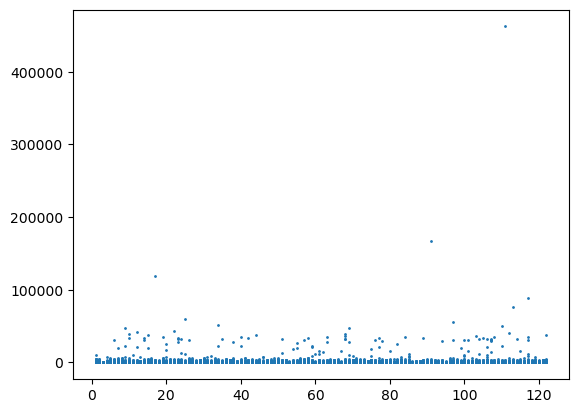

In [54]:
import matplotlib.pyplot as plt
import random

train_indices = random.sample(range(1, len(parking)), 10000)
val_indices = random.sample(range(1, len(parking)), 10000)
test_indices = random.sample(range(1, len(parking)), 10000)

train_sample = parking.to_numpy()[train_indices,:]
val_sample = parking.to_numpy()[val_indices,:]
test_sample = parking.to_numpy()[test_indices,:]

plt.plot(train_sample[:,2], train_sample[:,0], "o", markersize = 1)
# plt.ylim((0,10000))

In [96]:
X_train = torch.tensor(train_sample[:,range(2,4)], dtype = torch.float32) # range interval is [a,b)
y_train = torch.tensor(train_sample[:,0], dtype = torch.float32)

X_val = torch.tensor(val_sample[:,range(2,4)], dtype = torch.float32)
y_val = torch.tensor(val_sample[:,0], dtype = torch.float32)

X_test = torch.tensor(test_sample[:,range(2,4)], dtype = torch.float32)
y_test = torch.tensor(test_sample[:0], dtype = torch.float32)

In [99]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype = torch.float32)
X_val_scaled = torch.tensor(scaler.transform(X_val), dtype = torch.float32)
X_test_scaled = torch.tensor(scaler.transform(X_test), dtype = torch.float32)

In [100]:
gamma_namlss = GammaNAMLSS(X_train.shape[1])
gamma_namlss.fit(X_train_scaled, y_train, X_val_scaled, y_val)

Epoch 0 - Train Loss: 1458.6831 - Max Grad: 0.4481 - Mean Grad: 0.0916
Epoch 0 - Train Loss: 1458.6831 - Val Loss: 1296.9183
Epoch 10 - Train Loss: 1395.6428 - Max Grad: 0.4514 - Mean Grad: 0.0914
Epoch 20 - Train Loss: 1335.3409 - Max Grad: 0.4547 - Mean Grad: 0.0911


KeyboardInterrupt: 

In [ ]:
alpha, beta = gamma_namlss.predict(X_test_scaled)
gamma_dist = dist.Gamma(alpha, beta)

In [70]:
from scipy.stats import gamma

quantiles = gamma.ppf([0.025, 0.975], alpha, scale = 1/beta)
quantiles

array([[6.77700585e-01, 5.95324103e+03],
       [6.77576056e-01, 5.95360647e+03],
       [9.12045840e-01, 5.11211387e+03],
       ...,
       [6.77562252e-01, 5.95379816e+03],
       [6.77565542e-01, 5.95378027e+03],
       [6.77562252e-01, 5.95379816e+03]])

In [71]:
lower = quantiles[:,0]
upper = quantiles[:,1]

(0.0, 50000.0)

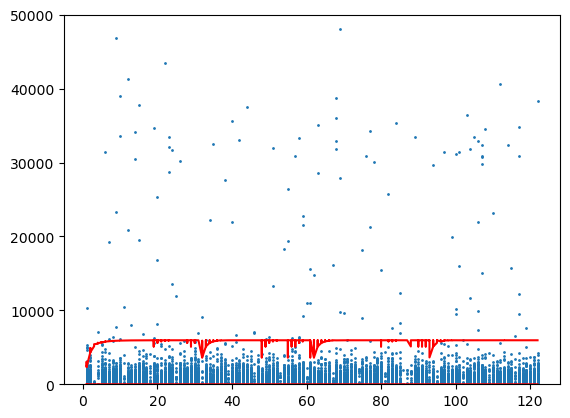

In [ ]:
import numpy as np

sorted_indices = np.argsort(X_test[:,0])
X_test_sorted = X_test[sorted_indices, 0]
y_test_sorted = y_test[sorted_indices]

plt.plot(X_test_sorted, y_test_sorted, "o", markersize = 1)
plt.plot(X_test_sorted, lower[sorted_indices], color = "red")
plt.plot(X_test_sorted, upper[sorted_indices], color = "red")
plt.ylim((0, 50000))

In [ ]:
robust_gamlss = GammaNAMLSS(X_train.shape[1])
robust_gamlss.fit(X_train_scaled, y_train, X_val_scaled, y_val, robustness_factor = torch.tensor(10))

Epoch 0 - Train Loss: 9.7851 - Max Grad: 0.1951 - Mean Grad: 0.0538
Epoch 0 - Train Loss: 9.7851 - Val Loss: 9.7642
Epoch 10 - Train Loss: 9.7437 - Max Grad: 0.2253 - Mean Grad: 0.0617
Epoch 20 - Train Loss: 9.6968 - Max Grad: 0.2444 - Mean Grad: 0.0667
Epoch 30 - Train Loss: 9.6464 - Max Grad: 0.2542 - Mean Grad: 0.0692
Epoch 40 - Train Loss: 9.5941 - Max Grad: 0.2585 - Mean Grad: 0.0703
Epoch 50 - Train Loss: 9.5413 - Max Grad: 0.2596 - Mean Grad: 0.0705
Epoch 60 - Train Loss: 9.4887 - Max Grad: 0.2597 - Mean Grad: 0.0705
Epoch 70 - Train Loss: 9.4362 - Max Grad: 0.2639 - Mean Grad: 0.0714
Epoch 80 - Train Loss: 9.3822 - Max Grad: 0.2833 - Mean Grad: 0.0740
Epoch 90 - Train Loss: 9.3250 - Max Grad: 0.2947 - Mean Grad: 0.0734
Epoch 100 - Train Loss: 9.2654 - Max Grad: 0.2868 - Mean Grad: 0.0731
Epoch 100 - Train Loss: 9.2654 - Val Loss: 9.2214
Epoch 110 - Train Loss: 9.2043 - Max Grad: 0.2927 - Mean Grad: 0.0726
Epoch 120 - Train Loss: 9.1417 - Max Grad: 0.2965 - Mean Grad: 0.0719
Epo

GammaNAMLSS(
  (submodules): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=1, out_features=8, bias=True)
      (1): Tanh()
      (2): Linear(in_features=8, out_features=2, bias=True)
    )
  )
)

In [ ]:
robust_alpha, robust_beta = robust_gamlss.predict(X_test_scaled)

In [89]:
from scipy.stats import gamma

quantiles = gamma.ppf([0.025, 0.975], robust_alpha, scale = 1/robust_beta)
quantiles

robust_lower = quantiles[:,0]
robust_upper = quantiles[:,1]

(0.0, 4000.0)

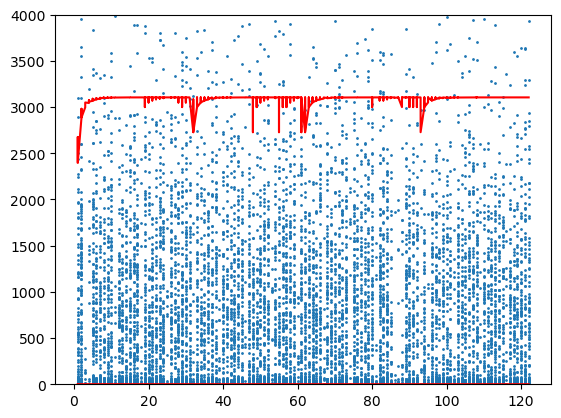

In [ ]:
plt.plot(X_test_sorted, y_test_sorted, "o", markersize = 1)
plt.plot(X_test_sorted, robust_lower[sorted_indices], color = "red")
plt.plot(X_test_sorted, robust_upper[sorted_indices], color = "red")
plt.ylim((0,4000))

Ideen:
- X_test_sorted vs. Alpha und X_test_sorted vs. Beta plotten (Quantile falsch berechnet, Plotting Fehler, oder immer gleiche Parameter gefittet?)